In [115]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, col, when, lit, sum
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report, confusion_matrix
from smote_sampling import vectorizerFunction, SmoteSampling
import numpy as np
import matplotlib.pyplot as plt

In [116]:
# postavlja konfiguraciju SparkSession objekta za lokalni način rada (1 komp)
spark = SparkSession.builder \
    .master("local") \
    .appName("StrokePrediction") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()
spark.sparkContext.setLogLevel("WARN")
dataset_df = spark.read.csv(
    'hes_a_SMOTE_operator.csv', inferSchema=True, header=True)




dataset_df = dataset_df.withColumn("hypertension", col("hypertension").cast("integer"))
dataset_df = dataset_df.withColumn("heart_disease", col("heart_disease").cast("integer"))
dataset_df.printSchema()
dataset_df.describe().show(2)  # sveukupna statistika, prva 2 reda

root
 |-- id: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)

+-------+-----------------+------+-----------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|summary|               id|gender|              age|       hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|             stroke|
+-------+-----------------+------+-----------------+-------------------+----------------

In [117]:
# proverava se je l' postoje neke kolone koje imaju nedostajuce vrednosti
dataset_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in dataset_df.columns]).show()

# ovde moze i za neku specificnu:
column_name = 'stroke'
dataset_df.select(sum(col(column_name).isNull().cast("int")).alias(column_name)).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+

+------+
|stroke|
+------+
|     0|
+------+



In [119]:
dataset_df = dataset_df.drop('id')  # izbacuje se id

mean_bmi = dataset_df.select(mean(col('bmi'))).first()[
    0]  # uzimam srednju vrednost bmi iz kolone

dataset_df = dataset_df.withColumn('bmi', when(
    col('bmi') == "N/A", mean_bmi).otherwise(col('bmi')))  # menjaj svuda gde je "N/A"

dataset_df = dataset_df.withColumn("bmi", dataset_df["bmi"].cast(
    "double"))  # bmi je bio string sad je double

dataset_df.show(15)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|               bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|              36.6|formerly smoked|     1|
|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|29.656603525388007|   never smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|              32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|              34.4|         smokes|     1|

+------+-----+
|stroke|count|
+------+-----+
|     1| 4786|
|     0| 4861|
+------+-----+

+--------------+-----+
|Residence_type|count|
+--------------+-----+
|         Urban| 5538|
|         Rural| 4109|
+--------------+-----+

+------------+-----+
|ever_married|count|
+------------+-----+
|          No| 2462|
|         Yes| 7185|
+------------+-----+

+---------------+-----+
| smoking_status|count|
+---------------+-----+
|         smokes| 1469|
|        Unknown| 2158|
|   never smoked| 3644|
|formerly smoked| 2376|
+---------------+-----+

+------------+-----+
|hypertension|count|
+------------+-----+
|           1| 1482|
|           0| 8165|
+------------+-----+

+------+-----+
|gender|count|
+------+-----+
|Female| 5277|
| Other|    1|
|  Male| 4369|
+------+-----+

+-------------+-----+
|heart_disease|count|
+-------------+-----+
|            1| 1163|
|            0| 8484|
+-------------+-----+

+-------------+-----+
|    work_type|count|
+-------------+-----+
| Never_worked|  2

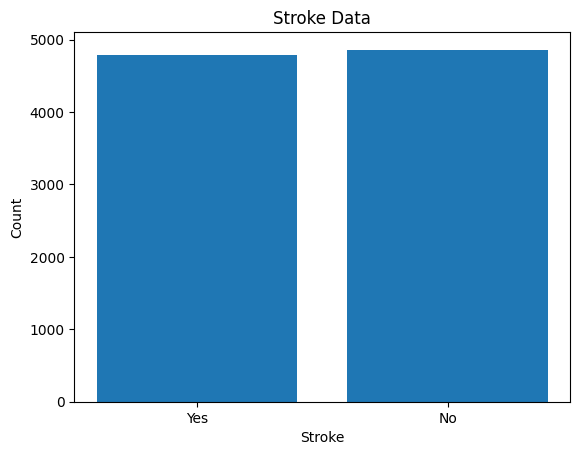

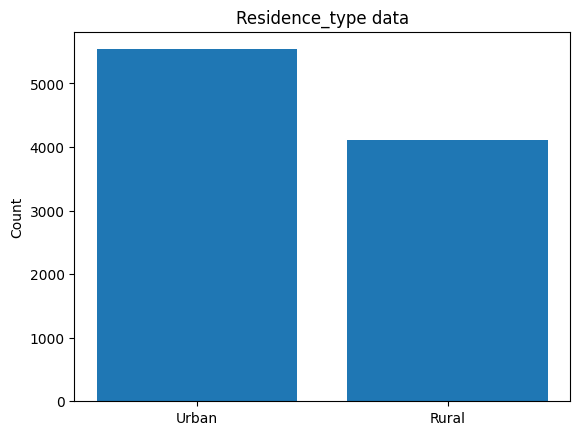

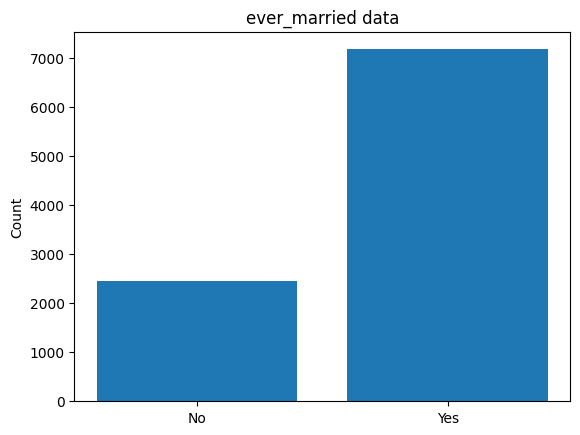

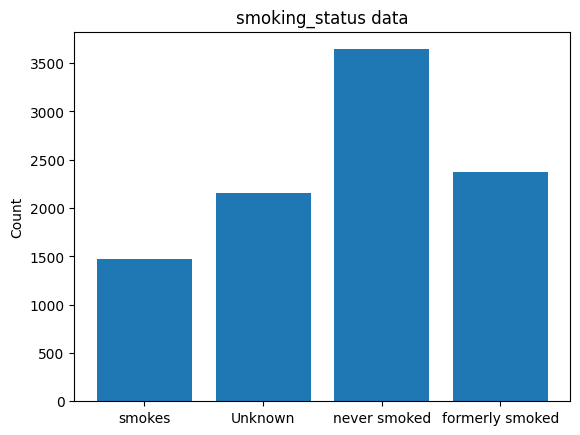

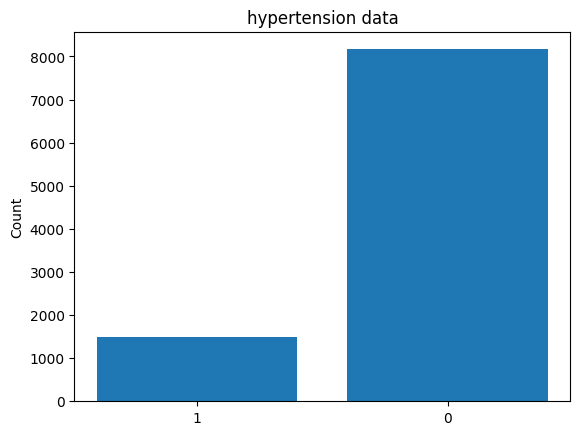

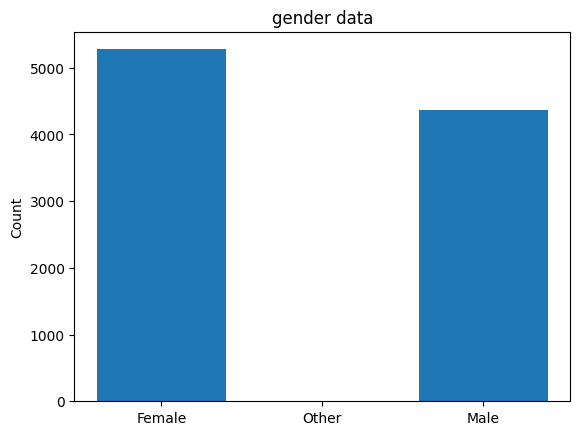

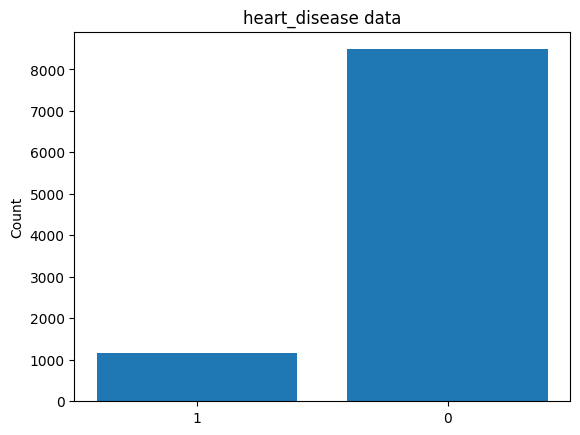

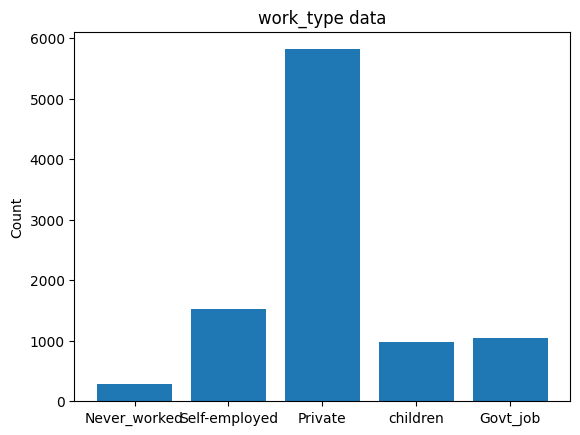

In [120]:
feature_columns = dataset_df.columns[:-1]
numerical_feature_columns = [col for col, dtype in dataset_df.dtypes if dtype == 'double'] # = ["age", "avg_glucose_level", "bmi"]
nominal_feature_columns = list(set(feature_columns) - set(numerical_feature_columns))

dataset_df.groupby("stroke").count().show()
data = dataset_df.groupby("stroke").count().collect() 

for column in nominal_feature_columns:
    dataset_df.groupby(column).count().show()
data = dataset_df.groupby("stroke").count().collect()

labels = ["No" if row['stroke'] == 0 else "Yes" for row in data]
counts = [row['count'] for row in data]

plt.bar(labels, counts)
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.title('Stroke Data')
plt.show()

for column in nominal_feature_columns:
    grouped_data = dataset_df.groupby(column).count()
    data = grouped_data.collect()

    labels = [str(row[column]) for row in data]
    counts = [int(row['count']) for row in data]

    plt.bar(labels, counts)
    plt.ylabel('Count')
    plt.title(f'{column} data')
    plt.show()


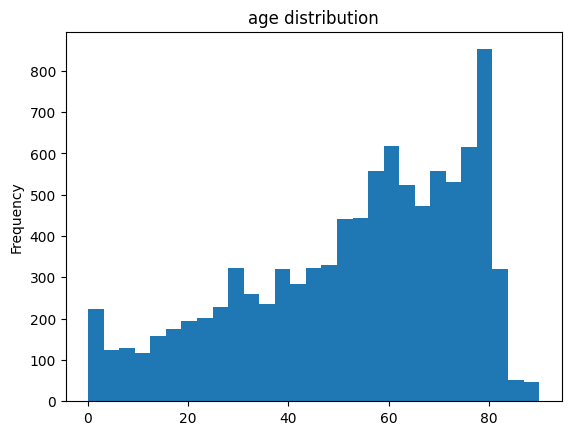

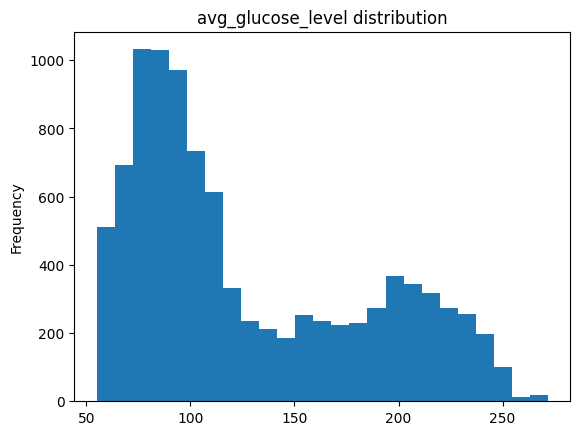

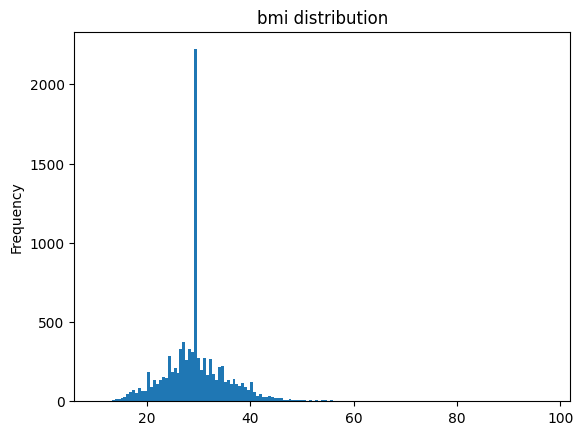

In [121]:
for column in numerical_feature_columns:
    values = dataset_df.select(column).rdd.flatMap(lambda x: x).collect()

    plt.hist(values, bins='auto')
    plt.ylabel('Frequency')
    plt.title(f'{column} distribution')
    plt.show()

In [122]:
# izdvoji kolone sa string tipom podataka
string_columns = [col for col, dtype in dataset_df.dtypes if dtype == 'string']
encoded_cols = list()
stages = list()
# Rade se StringIndexer i OneHotEncoder faze
for column in string_columns:
    # MNOBO JE VAŽNO OVO INVALID DA HENDLUJE JER SAM SE NAMUČILAAAAAAA BEZ TOGA
    indexer = StringIndexer(
        inputCol=column, outputCol=column + "_index", handleInvalid="keep")
    encoder = OneHotEncoder(
        inputCols=[column + "_index"], outputCols=[column + "_encoded"])
    stages += [indexer, encoder]

# Create a Pipeline with the stages, ovo je s chatgpt jer moj kod nije hteo da radi bez pipeline :DDDDDD
pipeline = Pipeline(stages=stages)

# Fit and transform the pipeline on the DataFrame (gle ovde transform oce da radi :DDDDDDDDDDDDDDD)
encoded_df = pipeline.fit(dataset_df).transform(dataset_df)
encoded_df.show(10)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+---------------+------+------------+--------------+------------------+--------------------+---------------+-----------------+--------------------+----------------------+--------------------+----------------------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|               bmi| smoking_status|stroke|gender_index|gender_encoded|ever_married_index|ever_married_encoded|work_type_index|work_type_encoded|Residence_type_index|Residence_type_encoded|smoking_status_index|smoking_status_encoded|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+---------------+------+------------+--------------+------------------+--------------------+---------------+-----------------+--------------------+----------------------+--------------------+----------------------+
|

In [123]:
# iterira se kroz sve string kolone i menja se originalno s enkodiranim vrednostima, a index vrednosti se dropuju sta ce nam
for column in string_columns:
    encoded_col = column + "_encoded"
    index_col = column + "_index"
    mapping = encoded_df.select(column, index_col).distinct().collect()
    print(f"Vrednosti u koloni '{column}' se preslikavaju:")
    for row in mapping:
        print(f"{row[column]} -> {row[index_col]}")
    encoded_df = encoded_df.withColumn(column, col(
        encoded_col)).drop(encoded_col).drop(index_col)
dataset_df = encoded_df
dataset_df.show(10)

Vrednosti u koloni 'gender' se preslikavaju:
Male -> 1.0
Female -> 0.0
Other -> 2.0
Vrednosti u koloni 'ever_married' se preslikavaju:
Yes -> 0.0
No -> 1.0
Vrednosti u koloni 'work_type' se preslikavaju:
children -> 3.0
Private -> 0.0
Govt_job -> 2.0
Never_worked -> 4.0
Self-employed -> 1.0
Vrednosti u koloni 'Residence_type' se preslikavaju:
Rural -> 1.0
Urban -> 0.0
Vrednosti u koloni 'smoking_status' se preslikavaju:
formerly smoked -> 1.0
Unknown -> 2.0
smokes -> 3.0
never smoked -> 0.0
+-------------+----+------------+-------------+-------------+-------------+--------------+-----------------+------------------+--------------+------+
|       gender| age|hypertension|heart_disease| ever_married|    work_type|Residence_type|avg_glucose_level|               bmi|smoking_status|stroke|
+-------------+----+------------+-------------+-------------+-------------+--------------+-----------------+------------------+--------------+------+
|(3,[1],[1.0])|67.0|           0|            1|(2,[0],

In [124]:
feature_columns = ["gender", "age", "hypertension", "heart_disease", "ever_married",
                   "work_type", "Residence_type", "avg_glucose_level", "bmi",
                   "smoking_status"]

# kreiranje VectorAssemblera
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
dataset_df = assembler.transform(encoded_df)
dataset_df.show()

+-------------+----+------------+-------------+-------------+-------------+--------------+-----------------+------------------+--------------+------+--------------------+
|       gender| age|hypertension|heart_disease| ever_married|    work_type|Residence_type|avg_glucose_level|               bmi|smoking_status|stroke|            features|
+-------------+----+------------+-------------+-------------+-------------+--------------+-----------------+------------------+--------------+------+--------------------+
|(3,[1],[1.0])|67.0|           0|            1|(2,[0],[1.0])|(5,[0],[1.0])| (2,[0],[1.0])|           228.69|              36.6| (4,[1],[1.0])|     1|(21,[1,3,5,6,8,13...|
|(3,[0],[1.0])|61.0|           0|            0|(2,[0],[1.0])|(5,[1],[1.0])| (2,[1],[1.0])|           202.21|29.656603525388007| (4,[0],[1.0])|     1|(21,[0,3,6,9,14,1...|
|(3,[1],[1.0])|80.0|           0|            1|(2,[0],[1.0])|(5,[0],[1.0])| (2,[1],[1.0])|           105.92|              32.5| (4,[0],[1.0])|   

In [125]:
# pravi se lista gde se instanciraju modeli (ovde mogu i svi ostali koji će da se koriste)
classifiers = [
    LogisticRegression(featuresCol="features", labelCol="stroke"),
    NaiveBayes(featuresCol="features", labelCol="stroke"),
    LinearSVC(featuresCol="features", labelCol="stroke"),
    DecisionTreeClassifier(featuresCol="features", labelCol="stroke"),
    RandomForestClassifier(featuresCol="features", labelCol="stroke")
]

In [126]:
auc_scores = list()
f1_scores = list()
accuracy_scores = list()
precision_scores = list()
recall_scores = list()
classifier_names = list()

for classifier in classifiers:
    print(
        f'Klasifikator {classifier.__class__.__name__} s 30:70 test:trening podelom podataka:')

    train_data, test_data = dataset_df.randomSplit([0.7, 0.3], seed=42)

    # model se pravi na osnovu trening podataka
    model = classifier.fit(train_data)
    # prave se predikcije s test podacima
    predictions = model.transform(test_data)

    predicted_strokes = np.array(predictions.select(
        "prediction").rdd.flatMap(lambda x: x).collect())  # predikcije
    
    actual_strokes = np.array(predictions.select("stroke").rdd.flatMap(
        lambda x: x).collect())  # ekšual stronks (desilo se)

    print(
        f'Evaluacija {classifier.__class__.__name__} klasifikatora za 30:70 test:trening podelu podataka:')
    print(classification_report(actual_strokes, predicted_strokes, zero_division=1))
    report = classification_report(actual_strokes, predicted_strokes, zero_division=1, output_dict=True)
    f1_scores.append(report['macro avg']['f1-score'])
    accuracy_scores.append(report['accuracy'])
    precision_scores.append(report['macro avg']['precision'])
    recall_scores.append(report['macro avg']['recall'])
    print("Matrica konfuzije:")
    print(confusion_matrix(actual_strokes, predicted_strokes))

    evaluator = BinaryClassificationEvaluator(labelCol="stroke")
    auc = evaluator.evaluate(predictions)
    print("Površina ispod ROC krive (AUC):", auc)
    print("------------------------------------")
    classifier_names.append(classifier.__class__.__name__)
    auc_scores.append(auc)

Klasifikator LogisticRegression s 30:70 test:trening podelom podataka:
Evaluacija LogisticRegression klasifikatora za 30:70 test:trening podelu podataka:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1387
           1       0.78      0.82      0.80      1407

    accuracy                           0.79      2794
   macro avg       0.79      0.79      0.79      2794
weighted avg       0.79      0.79      0.79      2794

Matrica konfuzije:
[[1054  333]
 [ 258 1149]]
Površina ispod ROC krive (AUC): 0.8651799709865574
------------------------------------
Klasifikator NaiveBayes s 30:70 test:trening podelom podataka:
Evaluacija NaiveBayes klasifikatora za 30:70 test:trening podelu podataka:
              precision    recall  f1-score   support

           0       0.81      0.69      0.75      1387
           1       0.73      0.84      0.78      1407

    accuracy                           0.77      2794
   macro avg       0.77      

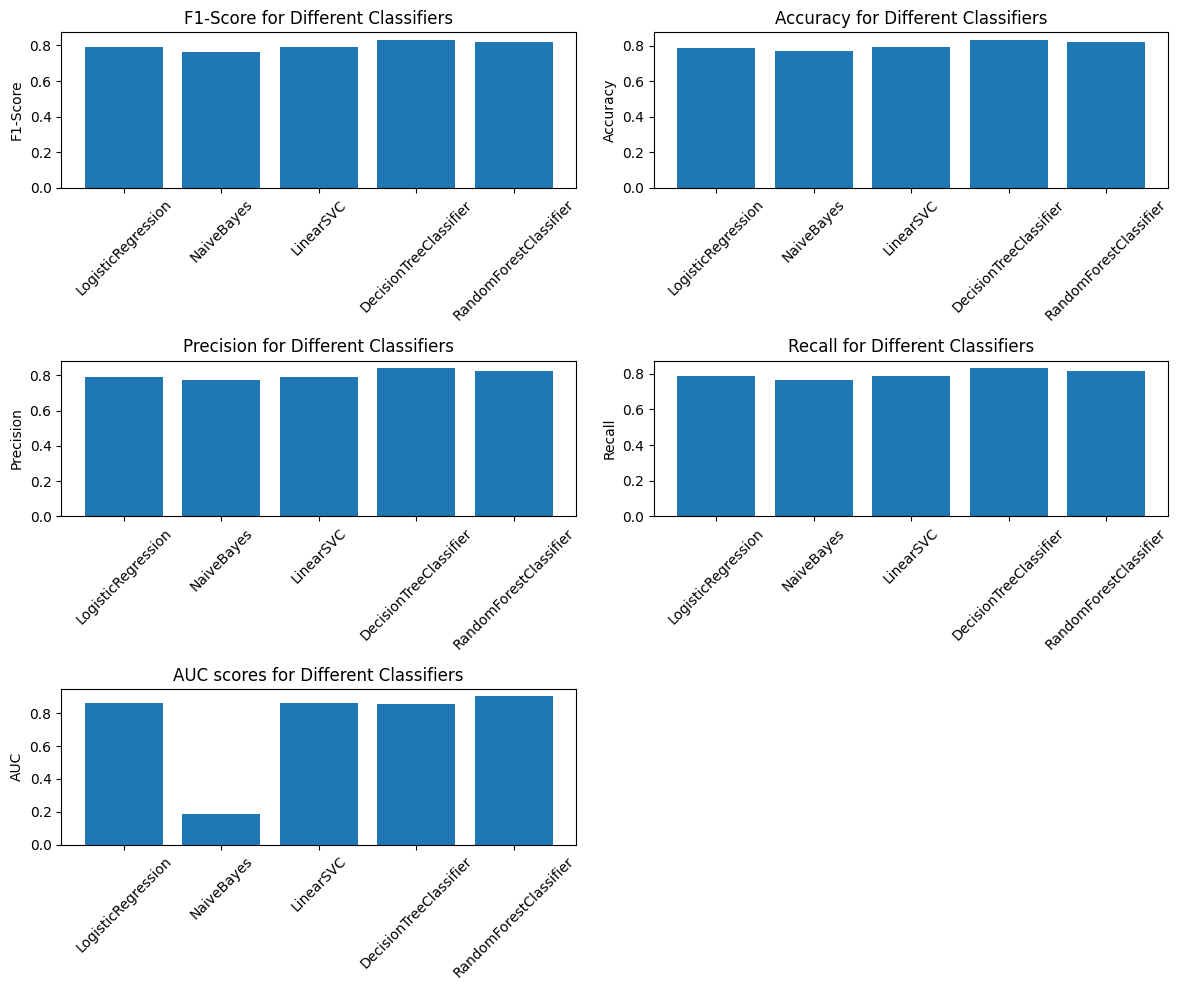

In [129]:
plt.figure(figsize=(12, 10))
# F1-Score subplot
plt.subplot(3, 2, 1)
plt.bar(range(len(classifier_names)), f1_scores)
plt.xticks(range(len(classifier_names)), classifier_names, rotation=45)
plt.ylabel('F1-Score')
plt.title('F1-Score for Different Classifiers')

# Accuracy subplot
plt.subplot(3, 2, 2)
plt.bar(range(len(classifier_names)), accuracy_scores)
plt.xticks(range(len(classifier_names)), classifier_names, rotation=45)
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Classifiers')

# Precision subplot
plt.subplot(3, 2, 3)
plt.bar(range(len(classifier_names)), precision_scores)
plt.xticks(range(len(classifier_names)), classifier_names, rotation=45)
plt.ylabel('Precision')
plt.title('Precision for Different Classifiers')

# Recall subplot
plt.subplot(3, 2, 4)
plt.bar(range(len(classifier_names)), recall_scores)
plt.xticks(range(len(classifier_names)), classifier_names, rotation=45)
plt.ylabel('Recall')
plt.title('Recall for Different Classifiers')

plt.subplot(3, 2, 5)
plt.bar(range(len(classifier_names)), auc_scores)
plt.xticks(range(len(classifier_names)), classifier_names, rotation=45)
plt.ylabel('AUC')
plt.title('AUC scores for Different Classifiers')

plt.tight_layout()
plt.show()

# plt.figure(figsize=(10, 6))
# plt.bar(range(len(classifier_names)), auc_scores)
# plt.ylabel('AUC Score')
# plt.title('AUC Scores for Different Classifiers')
# plt.xticks(range(len(classifier_names)), classifier_names, rotation=45)
# plt.tight_layout()

# Prikazi plot
# plt.show()

In [130]:
auc_scores_CV = list()
f1_scores_CV = list()
accuracy_scores_CV = list()
precision_scores_CV = list()
recall_scores_CV = list()
classifier_names_CV = list()
for classifier in classifiers:
    print(f'Klasifikator {classifier.__class__.__name__} sa cross-validation:')

# Ovde se pomocu grida testiraju najbolji parametri za konkretni klasifikator, ima raznih

    # smoothing se koristi kako bi se izbeglo da model dodeli nultu verovatnoću nekom atributu koji se nije pojavio u trening skupu podataka
    if isinstance(classifier, NaiveBayes):
        paramGrid = ParamGridBuilder() \
            .addGrid(classifier.smoothing, [0.1, 0.5, 1.0]) \
            .build()
        
    elif isinstance(classifier, DecisionTreeClassifier):
        # MaxDepth je maksimalna dubina stabla koju dozvoljava Decision Tree algoritam
        # MaxBins predstavlja maksimalni broj binova koji će se koristiti prilikom diskretizacije numeričkih atributa u Decision Tree algoritmu
        paramGrid = ParamGridBuilder() \
            .addGrid(classifier.maxDepth, [2, 5, 10]) \
            .addGrid(classifier.maxBins, [10, 20, 30]) \
            .build()

    elif isinstance(classifier, RandomForestClassifier):
        # NumTrees je broj stabala koji će biti konstruisani u Random Forest algoritmu
        paramGrid = ParamGridBuilder() \
            .addGrid(classifier.numTrees, [50, 100, 150]) \
            .addGrid(classifier.maxDepth, [2, 5, 10]) \
            .build()
    else:
        # regParam kontroliše jačinu regularizacije (manje vrednosti regParam smanjuju regularizaciju, dok veće vrednosti je pojačavaju), što znači da smanjuje overfitting
        # MaxIter je maksimalni broj iteracija koje će alg. izvršiti prilikom učenja modela
        paramGrid = ParamGridBuilder() \
            .addGrid(classifier.regParam, [0.01, 0.1, 1.0]) \
            .addGrid(classifier.maxIter, [10, 20, 30]) \
            .build()

    crossval = CrossValidator(estimator=classifier,
                              estimatorParamMaps=paramGrid,
                              evaluator=BinaryClassificationEvaluator(
                                  labelCol="stroke"),
                              numFolds=5)

    cv_model = crossval.fit(dataset_df)  # kreira model
    best_model = cv_model.bestModel  # uzima najbolji
    predictions = best_model.transform(dataset_df)

    predicted_strokes = np.array(predictions.select(
        "prediction").rdd.flatMap(lambda x: x).collect())  # predikcije
    
    actual_strokes = np.array(predictions.select("stroke").rdd.flatMap(
        lambda x: x).collect())  # desilose

    print(
        f'Evaluacija {classifier.__class__.__name__} klasifikatora za cross-validation podelu podataka:')
    print(classification_report(actual_strokes, predicted_strokes, zero_division=1))
    report = classification_report(actual_strokes, predicted_strokes, zero_division=1, output_dict=True)
    f1_scores_CV.append(report['macro avg']['f1-score'])
    accuracy_scores_CV.append(report['accuracy'])
    precision_scores_CV.append(report['macro avg']['precision'])
    recall_scores_CV.append(report['macro avg']['recall'])
    print("Matrica konfuzije:")
    print(confusion_matrix(actual_strokes, predicted_strokes))

    evaluator = BinaryClassificationEvaluator(labelCol="stroke")
    auc = evaluator.evaluate(predictions)
    print("Površina ispod ROC krive (AUC):", auc)
    print("------------------------------------")
    classifier_names_CV.append(classifier.__class__.__name__)
    auc_scores_CV.append(auc)

Klasifikator LogisticRegression sa cross-validation:
Evaluacija LogisticRegression klasifikatora za cross-validation podelu podataka:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      4861
           1       0.78      0.81      0.79      4786

    accuracy                           0.79      9647
   macro avg       0.79      0.79      0.79      9647
weighted avg       0.79      0.79      0.79      9647

Matrica konfuzije:
[[3759 1102]
 [ 923 3863]]
Površina ispod ROC krive (AUC): 0.8665327358398835
------------------------------------
Klasifikator NaiveBayes sa cross-validation:
Evaluacija NaiveBayes klasifikatora za cross-validation podelu podataka:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      4861
           1       0.74      0.83      0.78      4786

    accuracy                           0.77      9647
   macro avg       0.78      0.77      0.77      9647
weighted avg   

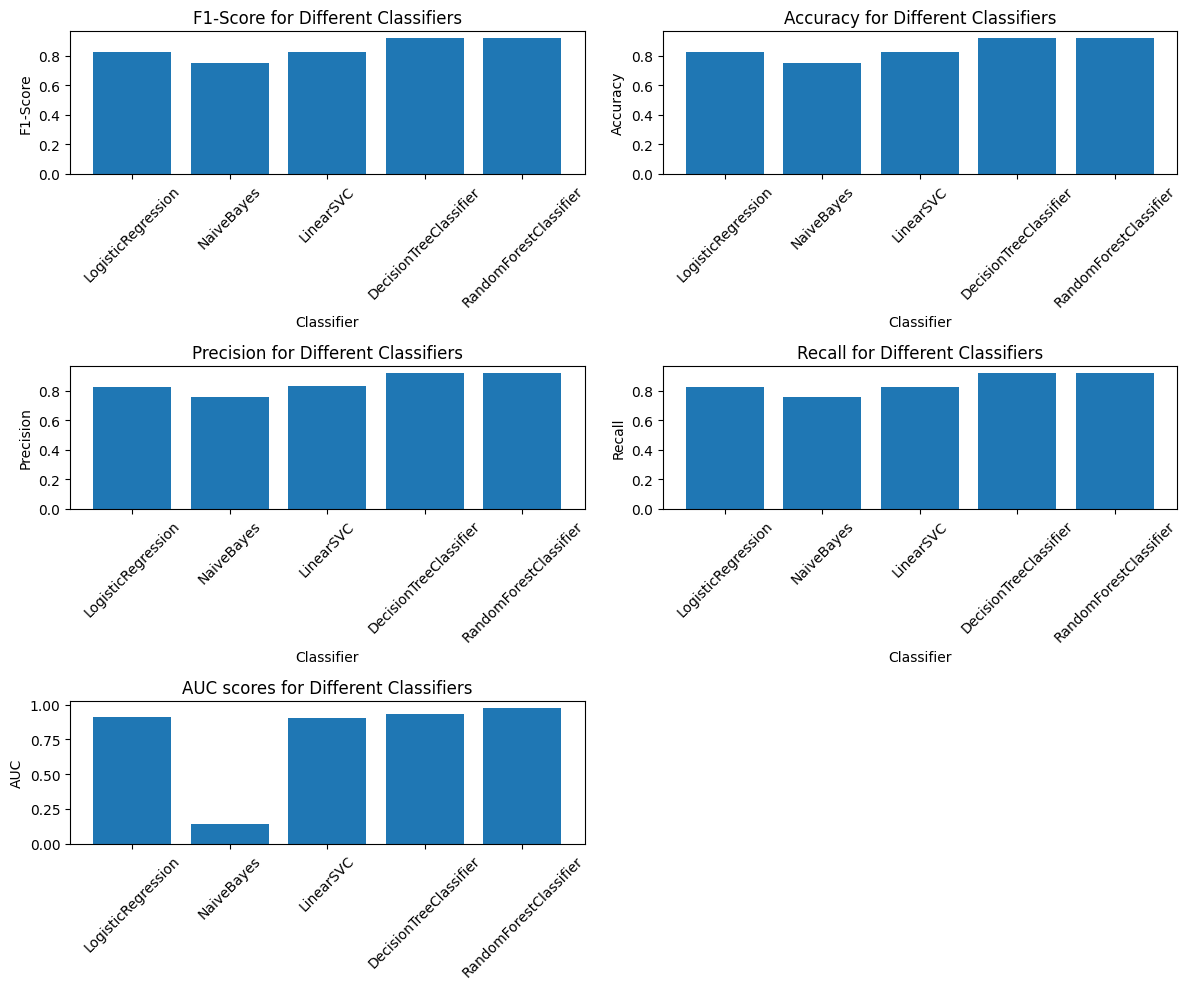

In [57]:
plt.figure(figsize=(12, 10))
# F1-Score subplot
plt.subplot(3, 2, 1)
plt.bar(range(len(classifier_names_CV)), f1_scores_CV)
plt.xticks(range(len(classifier_names_CV)), classifier_names_CV, rotation=45)
plt.xlabel('Classifier')
plt.ylabel('F1-Score')
plt.title('F1-Score for Different Classifiers')

# Accuracy subplot
plt.subplot(3, 2, 2)
plt.bar(range(len(classifier_names_CV)), accuracy_scores_CV)
plt.xticks(range(len(classifier_names_CV)), classifier_names_CV, rotation=45)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Classifiers')

# Precision subplot
plt.subplot(3, 2, 3)
plt.bar(range(len(classifier_names_CV)), precision_scores_CV)
plt.xticks(range(len(classifier_names_CV)), classifier_names_CV, rotation=45)
plt.xlabel('Classifier')
plt.ylabel('Precision')
plt.title('Precision for Different Classifiers')

# Recall subplot
plt.subplot(3, 2, 4)
plt.bar(range(len(classifier_names_CV)), recall_scores_CV)
plt.xticks(range(len(classifier_names_CV)), classifier_names_CV, rotation=45)
plt.xlabel('Classifier')
plt.ylabel('Recall')
plt.title('Recall for Different Classifiers')

plt.subplot(3, 2, 5)
plt.bar(range(len(classifier_names_CV)), auc_scores_CV)
plt.xticks(range(len(classifier_names_CV)), classifier_names_CV, rotation=45)
plt.ylabel('AUC')
plt.title('AUC scores for Different Classifiers')

plt.tight_layout()
plt.show()